# Pipeline for High-z Radio Galaxies 12: Application of full pipeline for prediction with naive thresholds

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
import pandas as pd
import mpl_scatter_density
from joblib import dump, load
import global_variables as gv

In [2]:
mpl.rcdefaults()

Create path effects.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    try:
        med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    except:
        med = np.nanmedian(np.abs(z_true - z_pred))
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    try:
        med  = np.nanmedian(np.abs(frac)).astype('float32')
    except:
        med  = np.nanmedian(np.abs(frac))
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    try:
        rot = np.sqrt(ssq / len(z_true)).astype('float32')
    except:
        rot = np.sqrt(ssq / len(z_true))
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    try:
        rot = np.sqrt(ssq / len(z_true)).astype('float32')
    except:
        rot = np.sqrt(ssq / len(z_true))
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    try:
        siz  = np.sum(np.isfinite(dif)).astype('float32')
        num  = np.sum(np.array(dif > 0.15)).astype('float32')
    except:
        siz  = np.sum(np.isfinite(dif))
        num  = np.sum(np.array(dif > 0.15))
    frac = num / siz
    return frac

Methods for Pycaret and saved models.

In [9]:
def get_final_column_names(pycaret_pipeline, sample_df, verbose=False):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                if verbose:
                    print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    if verbose:
                        print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    if verbose:
                        print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [10]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

Methods for the use of values in Confusion Matrices.

In [11]:
def flatten_CM(cm_array):
    try:
        TN, FP, FN, TP = cm_array.flatten().astype('float32')
    except:
        TN, FP, FN, TP = cm_array.flatten()
    return TN, FP, FN, TP

In [12]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = flatten_CM(cm_array)
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [13]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = flatten_CM(cm_array)
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [14]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = flatten_CM(cm_array)
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [15]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = flatten_CM(cm_array)
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [16]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(stretch=PowerStretch(0.35))

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal', values_format=',')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(28)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=16)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [17]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.5))

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=gv.seed)),\
            (1 + predicted_z.sample(frac=1, random_state=gv.seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta Z / (1 + Z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + Z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + Z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

Functions to predict values

In [18]:
def predict_star(catalog_df, star_model, threshold, raw_score=True):
    catalog_df = pyc.predict_model(star_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_1'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    catalog_df.loc[:, 'Score_no_star'] = np.around(catalog_df.loc[:, 'Score_no_star'], decimals=7)
    return catalog_df

In [19]:
def predict_AGN_gal(catalog_df, AGN_gal_model, cal_AGN_gal_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(AGN_gal_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
    catalog_df.loc[:, 'Score_AGN'] = np.around(catalog_df.loc[:, 'Score_AGN'], decimals=7)
    pred_probs = cal_AGN_gal_model.predict_proba(catalog_df.loc[:, get_final_column_names(AGN_gal_model, catalog_df)])[:, 1]
    catalog_df['Prob_AGN'] = pred_probs
    return catalog_df

In [20]:
def predict_radio_det(catalog_df, radio_model, cal_radio_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(radio_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
    catalog_df.loc[:, 'Score_radio'] = np.around(catalog_df.loc[:, 'Score_radio'], decimals=7)
    pred_probs = cal_radio_model.predict_proba(catalog_df.loc[:, get_final_column_names(radio_model, catalog_df)])[:, 1]
    catalog_df['Prob_radio'] = pred_probs
    return catalog_df

In [21]:
def predict_z_full(catalog_df, redshift_model):
    catalog_df = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    catalog_df = catalog_df.rename(columns={'Label': 'pred_Z'})
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [22]:
def predict_z_high(catalog_df, redshift_model, z_lim, z_tol):
    catalog_df    = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    filter_pred_z = catalog_df.loc[:, 'pred_Z'] >= (z_lim + z_tol)
    catalog_df.loc[:, 'pred_Z'] = catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, catalog_df.loc[filter_pred_z, 'Label'])
    catalog_df    = catalog_df.drop(columns=['Label'])
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [23]:
def add_AGN_criteria(catalog_df):
    catalog_df['M12_AGN'] = M12_AGN_criterion(catalog_df)
    catalog_df['S12_AGN'] = S12_AGN_criterion(catalog_df)
    catalog_df['M16_AGN'] = M16_AGN_criterion(catalog_df)
    catalog_df['B18_AGN'] = B18_AGN_criterion(catalog_df)
    return catalog_df

In [24]:
def M12_AGN_criterion(catalog_df):
    M12_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 <
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 0.791) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 0.222) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           -3.172 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 7.624)).astype(int)
    return M12_column

In [25]:
def S12_AGN_criterion(catalog_df):
    S12_column = np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >= 0.8).astype(int)
    return S12_column

In [26]:
def M16_AGN_criterion(catalog_df):
    M16_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 < 4.4)).astype(int)
    return M16_column

In [27]:
def B18_AGN_criterion(catalog_df):
    B18_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 > 2.2) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           2 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 8.9)).astype(int)
    return B18_column

---

## Reading data

Flags.

In [28]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False  # z >= 2.0
use_third_z_model   = False  # z >= 3.0
use_fourth_z_model  = False  # z >= 3.7 (with SMOGN), or, if needed, z >= 4.0 ***
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [29]:
used_area           = 'COSMOS'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Validation'  # Validation, Training, Test, Test+Train

In [30]:
if used_area != 'S82':
    compare_A17_flag = False

In [31]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [32]:
feats_2_disc_S82    = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_HETDEX = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_COSMOS = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [33]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [34]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [35]:
if use_zeroth_model:
    full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)
elif not use_zeroth_model:
    full_catalog_df['is_str'] = np.zeros_like(full_catalog_df.loc[:, 'spCl'])

In [36]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [37]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

Show early statistics of confirmed sources

In [38]:
print(f'In the {used_area} field, there are {np.sum(full_catalog_df.loc[:, "class"] != 0.5):,} confirmed sources.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 0):,} of them are galaxies.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 1):,} of them are AGN.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 2):,} of them are stars.')

In the COSMOS field, there are 1,343 confirmed sources.
331 of them are galaxies.
1,012 of them are AGN.
0 of them are stars.


---

Split dataset if from HETDEX

In [39]:
if used_area == 'HETDEX':
    if use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
            (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
    elif not use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
    unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
    full_catalog_df   = full_catalog_df.loc[filter_known_spec]
    train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                        random_state=gv.seed, stratify=full_catalog_df.loc[:, 'class'])
    train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                        random_state=gv.seed, stratify=train_test_df.loc[:, 'class'])
    print('Shape of used data in HETDEX')
    print('(Confirmed galaxies and AGN)')
    print('-' * 50)
    print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
    print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
    print(f'Training data:                      {train_df.shape}')
    print(f'Testing data:                       {test_df.shape}')
    print(f'Unseen Data For Validation:         {validation_df.shape}')
    print('-' * 50)
    print()
    print(f'Using {HETDEX_subset} data from HETDEX')
    selected_dataset = {'Training': train_df, 'Test': test_df, 'Test+Train': train_test_df,\
                        'Validation': validation_df}
    full_catalog_df = selected_dataset[HETDEX_subset]

Split data if not from HETDEX

In [40]:
if used_area != 'HETDEX':
    filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                       (full_catalog_df.loc[:, 'class'] == 1) |\
                       (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
    unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
    full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [41]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (1343, 98)
--------------------------------------------------
Thus, it has 1,343 sources and 98 features.


Discard minor features.

In [42]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])

---

### Load models

In [43]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # 
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Predictions with naive thresholds ($0.5$).

In [44]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = predict_star(full_catalog_df, star_clf, gv.naive_star_thresh)
    unknown_cat_df  = predict_star(unknown_cat_df,  star_clf, gv.naive_star_thresh)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1
    unknown_cat_df['pred_star']      = 0
    unknown_cat_df['Score_no_star']  = 1

In [45]:
full_catalog_df = predict_AGN_gal(full_catalog_df, AGN_gal_clf, cal_AGN_gal_clf, gv.naive_AGN_thresh, gv.naive_AGN_thresh)
unknown_cat_df  = predict_AGN_gal(unknown_cat_df,  AGN_gal_clf, cal_AGN_gal_clf, gv.naive_AGN_thresh, gv.naive_AGN_thresh)

In [46]:
full_catalog_df = predict_radio_det(full_catalog_df, radio_det_clf, cal_radio_det_clf, gv.naive_radio_thresh, gv.naive_radio_thresh)
unknown_cat_df  = predict_radio_det(unknown_cat_df,  radio_det_clf, cal_radio_det_clf, gv.naive_radio_thresh, gv.naive_radio_thresh)

In [47]:
full_catalog_df = predict_z_full(full_catalog_df, redshift_reg)
unknown_cat_df  = predict_z_full(unknown_cat_df,  redshift_reg)

Additional columns with predictions.

In [48]:
full_catalog_df['pred_prob_class'] = (full_catalog_df.loc[:, 'Prob_AGN']   >= gv.naive_AGN_thresh).astype(int)
full_catalog_df['pred_prob_radio'] = (full_catalog_df.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)

unknown_cat_df['pred_prob_class']  = (unknown_cat_df.loc[:, 'Prob_AGN']   >= gv.naive_AGN_thresh).astype(int)
unknown_cat_df['pred_prob_radio']  = (unknown_cat_df.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)

Scores before applying further z models

In [49]:
if use_zeroth_model:
    temp_filt_pred_nstr    = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN        = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio'] == 1) &\
                             temp_filt_pred_nstr
sigma_mad_early            = sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_nmad_early           = sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_early              = sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_norm_early         = sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
out_frac_early             = outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])

In [50]:
temp_filt_pred_rAGN_prob   = np.array(full_catalog_df.loc[:, 'pred_prob_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_prob_radio'] == 1) &\
                             temp_filt_pred_nstr
sigma_mad_prob_early       = sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early      = sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_prob_early         = sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early    = sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
out_frac_prob_early        = outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])

In [51]:
temp_filt_high_z_rAGN       = temp_filt_pred_rAGN * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_early_hiz         = sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_nmad_early_hiz        = sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_early_hiz           = sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_norm_early_hiz      = sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
out_frac_early_hiz          = outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])

temp_filt_high_z_rAGN_prob  = temp_filt_pred_rAGN_prob * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_early_hiz    = sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early_hiz   = sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_prob_early_hiz      = sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early_hiz = sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
out_frac_prob_early_hiz     = outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])

In [52]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = predict_z_high(full_catalog_df, redshift_reg_2, gv.high_z_limit, redshift_tol)
    unknown_cat_df  = predict_z_high(unknown_cat_df,  redshift_reg_2, gv.high_z_limit, redshift_tol)

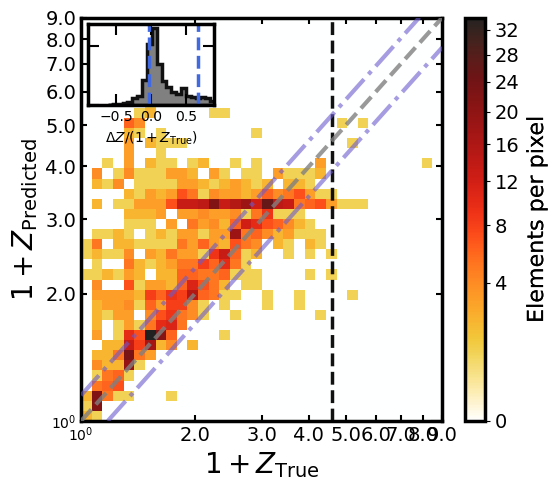

In [54]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + gv.high_z_limit), ls='--', c='k', lw=2.5)
if use_second_z_model or use_third_z_model or use_fourth_z_model:
    ax1.set_ylabel('$1 + Z_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

Additional columns with radio AGN prediction as a whole.

In [55]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['pred_prob_rAGN']     = np.array(full_catalog_df.loc[:, 'pred_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_prob_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_prob_radio'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_no_star'] *\
                                        full_catalog_df.loc[:, 'Score_AGN'] *\
                                        full_catalog_df.loc[:, 'Score_radio']
full_catalog_df['Prob_rAGN']          = full_catalog_df.loc[:, 'Prob_AGN'] *\
                                        full_catalog_df.loc[:, 'Prob_radio']
rad_score_scaler                      = MinMaxScaler()
rad_score_scaler.fit(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_radio'] = rad_score_scaler.transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [56]:
unknown_cat_df['pred_radio_AGN']     = np.array(unknown_cat_df.loc[:, 'pred_star']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
unknown_cat_df['pred_prob_rAGN']     = np.array(unknown_cat_df.loc[:, 'pred_star']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_prob_class'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_prob_radio'] == 1)
unknown_cat_df['Score_rAGN']         = unknown_cat_df.loc[:, 'Score_no_star'] *\
                                       unknown_cat_df.loc[:, 'Score_AGN'] *\
                                       unknown_cat_df.loc[:, 'Score_radio']
unknown_cat_df['Prob_rAGN']          = unknown_cat_df.loc[:, 'Prob_AGN'] *\
                                       unknown_cat_df.loc[:, 'Prob_radio']

unknown_cat_df['scaled_score_radio'] = rad_score_scaler.transform(unknown_cat_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
unknown_cat_df['scaled_score_rAGN']  = unknown_cat_df.loc[:, 'Score_AGN'] * unknown_cat_df.loc[:, 'scaled_score_radio']

In [57]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'pred_prob_class', 'radio_detect', 'pred_radio', 'pred_prob_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
full_catalog_df.loc[:, displayed_cols].describe()

,class,pred_class,pred_prob_class,radio_detect,pred_radio,pred_prob_radio,Z,pred_Z
count,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000
mean,0.753537,0.393894,0.390171,0.490692,0.265078,0.057334,1.068623,1.509294
std,0.431112,0.488794,0.487970,0.500100,0.441539,0.232567,0.815183,0.875060
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006230,0.046200
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441550,0.743600
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.880000,1.478600
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.518000,2.252400
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.149000,4.559700


##### Include AGN detection criteria from literature

In [58]:
full_catalog_df = add_AGN_criteria(full_catalog_df)
unknown_cat_df  = add_AGN_criteria(unknown_cat_df)

Obtain intermediate metrics

In [59]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
if use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1) |\
                        (full_catalog_df.loc[:, 'class'] == 2)
elif not use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 2))
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [61]:
if use_zeroth_model:
    filter_non_str_p      = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_p      = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_p        = full_catalog_df['pred_radio_AGN']
filt_hiz_rAGN_p           = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_p              = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p
filter_radio_p            = np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_p           = filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)
num_str_p                 = np.sum(full_catalog_df.loc[:, 'pred_star'] == 1)
num_AGN_p                 = np.sum(filter_AGN_p)
num_gal_p                 = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p)
num_radio_p               = np.sum(filter_radio_p)
num_radio_AGN_p           = np.sum(filter_radio_AGN_p)
num_rAGN_MQC_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_new_rAGN_p            = np.sum(filter_radio_AGN_p) - np.sum(filter_radio_AGN_t)

Some metrics for predicted classes based on probabilities (not scores).

In [62]:
filter_radio_AGN_prob_p   = full_catalog_df['pred_prob_rAGN']
filt_hiz_rAGN_prob_p      = filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_prob_p         = np.array(full_catalog_df.loc[:, 'pred_prob_class'] == 1) & filter_non_str_p
filter_radio_prob_p       = np.array(full_catalog_df.loc[:, 'pred_prob_radio'] == 1)
filt_new_rAGN_prob_p      = filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)

num_AGN_prob_p            = np.sum(filter_AGN_prob_p)
num_gal_prob_p            = np.sum(np.array(full_catalog_df.loc[:, 'pred_prob_class'] == 0) & filter_non_str_p)
num_radio_prob_p          = np.sum(filter_radio_prob_p)
num_radio_AGN_prob_p      = np.sum(filter_radio_AGN_prob_p)
num_rAGN_MQC_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_new_rAGN_prob_p       = np.sum(filter_radio_AGN_prob_p) - np.sum(filter_radio_AGN_t)

In [63]:
if use_zeroth_model:
    filter_non_str_unk_p      = np.array(unknown_cat_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_unk_p      = np.ones_like(unknown_cat_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_unk_p        = unknown_cat_df['pred_radio_AGN']
filt_hiz_rAGN_unk_p           = filter_radio_AGN_unk_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_p              = np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) & filter_non_str_unk_p
filter_radio_unk_p            = np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_unk_p           = filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)
num_str_unk_p                 = np.sum(unknown_cat_df.loc[:, 'pred_star'] == 1)
num_AGN_unk_p                 = np.sum(filter_AGN_unk_p)
num_gal_unk_p                 = np.sum(np.array(unknown_cat_df.loc[:, 'pred_class'] == 0) & filter_non_str_unk_p)
num_radio_unk_p               = np.sum(filter_radio_unk_p)
num_radio_AGN_unk_p           = np.sum(filter_radio_AGN_unk_p)
num_rAGN_MQC_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'radio_detect'] == 1))

In [64]:
filter_radio_AGN_unk_prob_p   = unknown_cat_df['pred_prob_rAGN']
filt_hiz_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_prob_p         = np.array(unknown_cat_df.loc[:, 'pred_prob_class'] == 1) & filter_non_str_unk_p
filter_radio_unk_prob_p       = np.array(unknown_cat_df.loc[:, 'pred_prob_radio'] == 1)
filt_new_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)

num_AGN_unk_prob_p            = np.sum(filter_AGN_unk_prob_p)
num_gal_unk_prob_p            = np.sum(np.array(unknown_cat_df.loc[:, 'pred_prob_class'] == 0) & filter_non_str_unk_p)
num_radio_unk_prob_p          = np.sum(filter_radio_unk_prob_p)
num_radio_AGN_unk_prob_p      = np.sum(filter_radio_AGN_unk_prob_p)
num_rAGN_MQC_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'radio_detect'] == 1))
num_new_rAGN_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p) - np.sum(filter_radio_AGN_t)

Confusion matrix for Star/not-star classification on confirmed sources (AGN + Galaxies + Stars)

In [65]:
if use_zeroth_model:
    cm_str = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 0) & np.array(full_catalog_df.loc[:, 'pred_star'] == 0)),\
                        np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 0) & np.array(full_catalog_df.loc[:, 'pred_star'] == 1))],\
                       [np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1) & np.array(full_catalog_df.loc[:, 'pred_star'] == 0)),\
                        np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1) & np.array(full_catalog_df.loc[:, 'pred_star'] == 1))]])

Confusion matrix for AGN prediction on confirmed sources (AGN/galaxies). Including initial prediction of not being star.

In [66]:
tmp_filt_AGN = filter_non_str_p * filter_known_spec
cm_AGN = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_class'] == 1))],\
                   [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_class'] == 1))]])

cm_AGN_prob = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_prob_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_prob_class'] == 1))],\
                   [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_prob_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                           np.array(full_catalog_df.loc[filter_non_str_p, 'pred_prob_class'] == 1))]])

Confusion matrices from literature AGN criteria.

In [67]:
tmp_filt_sp_nostr = filter_known_spec * filter_non_str_p
cm_AGN_S12 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))]])

cm_AGN_M12 = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 1))]])

cm_AGN_M16 = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 1))]])

cm_AGN_B18 = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 1))]])

Confusion matrix for radio detection prediction on confirmed sources (AGN/galaxies/stars)

In [68]:
cm_radio = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))]])

cm_radio_prob = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_prob_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_prob_p, 'pred_prob_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_prob_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_prob_p, 'pred_prob_radio']   == 1))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_prob_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_prob_p, 'pred_prob_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_prob_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_prob_p, 'pred_prob_radio']   == 1))]])

Confusion matrix for radio AGN prediction on confirmed sources (AGN/galaxies/stars)

In [69]:
cm_rAGN = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0) &\
                            np.array(full_catalog_df.loc[:,'pred_radio_AGN'] == 0)),\
                     np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0) &\
                            np.array(full_catalog_df.loc[:,'pred_radio_AGN'] == 1))],\
                    [np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 1) &\
                            np.array(full_catalog_df.loc[:,'pred_radio_AGN'] == 0)),\
                     np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 1) &\
                            np.array(full_catalog_df.loc[:,'pred_radio_AGN'] == 1))]])

cm_rAGN_prob = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0) &\
                            np.array(full_catalog_df.loc[:,'pred_prob_rAGN'] == 0)),\
                     np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0) &\
                            np.array(full_catalog_df.loc[:,'pred_prob_rAGN'] == 1))],\
                    [np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 1) &\
                            np.array(full_catalog_df.loc[:,'pred_prob_rAGN'] == 0)),\
                     np.sum(np.array(full_catalog_df.loc[:, 'radio_AGN'] == 1) &\
                            np.array(full_catalog_df.loc[:,'pred_prob_rAGN'] == 1))]])

Metrics from redshift predictions.

In [70]:
sigma_mad_field            = sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

sigma_mad_prob_field       = sigma_mad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field      = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_prob_field         = sigma_z(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field    = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
out_frac_prob_field        = outlier_frac(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])

In [71]:
filt_high_z_rAGN_p         = filter_radio_AGN_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_field_hiz        = sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_nmad_field_hiz       = sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_field_hiz          = sigma_z(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_norm_field_hiz     = sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
out_frac_field_hiz         = outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])

filt_high_z_rAGN_prob_p         = filter_radio_AGN_prob_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_field_hiz        = sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field_hiz       = sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_prob_field_hiz          = sigma_z(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field_hiz     = sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
out_frac_prob_field_hiz         = outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])

Plot histograms for scores.

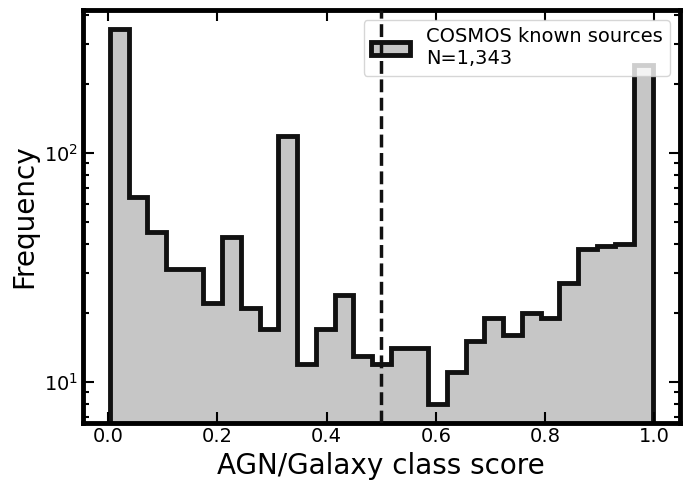

In [72]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_scores_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

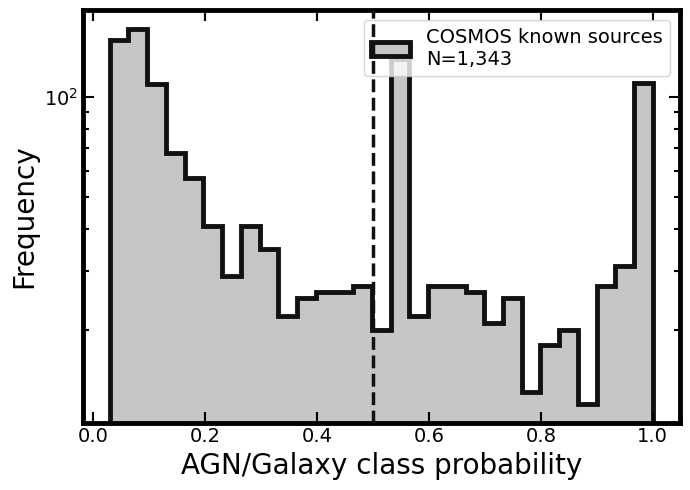

In [73]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

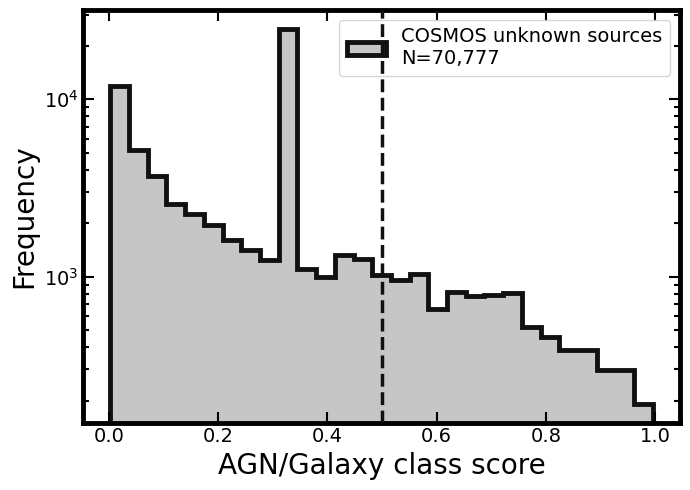

In [74]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_scores_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

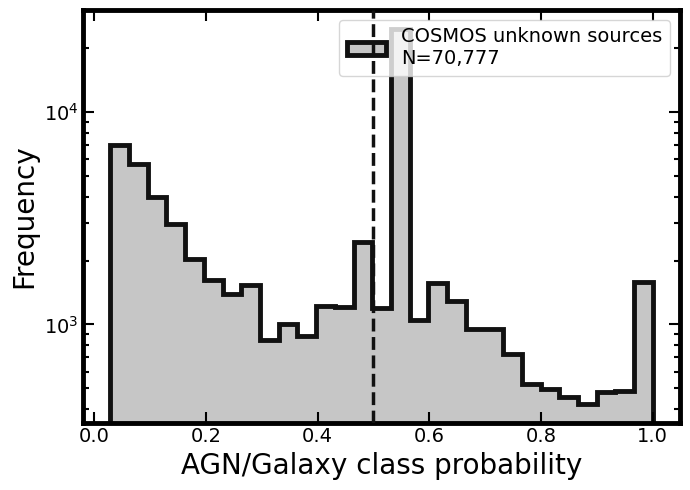

In [75]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

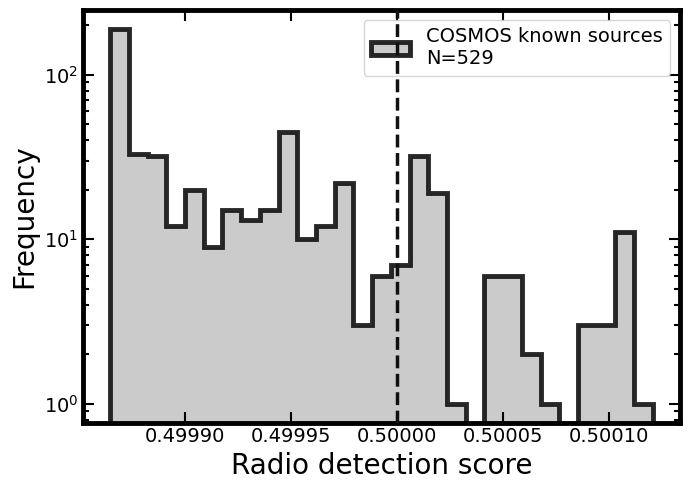

In [76]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_p)

ax1.hist(full_catalog_df.loc[filter_AGN_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_scores_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

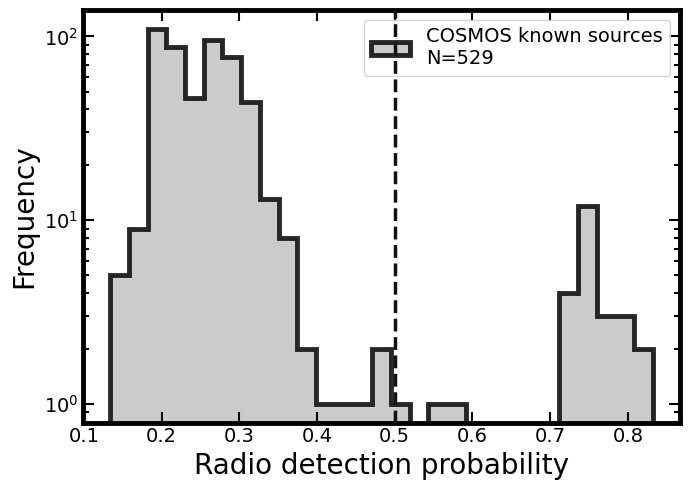

In [77]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_p, 'Prob_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_p)

ax1.hist(full_catalog_df.loc[filter_AGN_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_prob_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

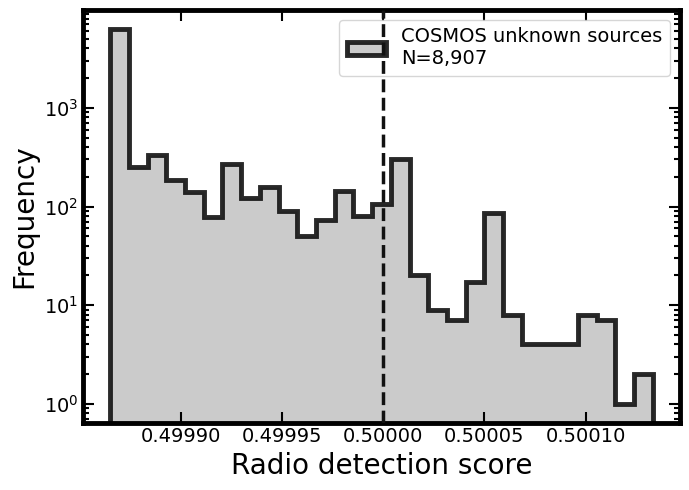

In [78]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_scores_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

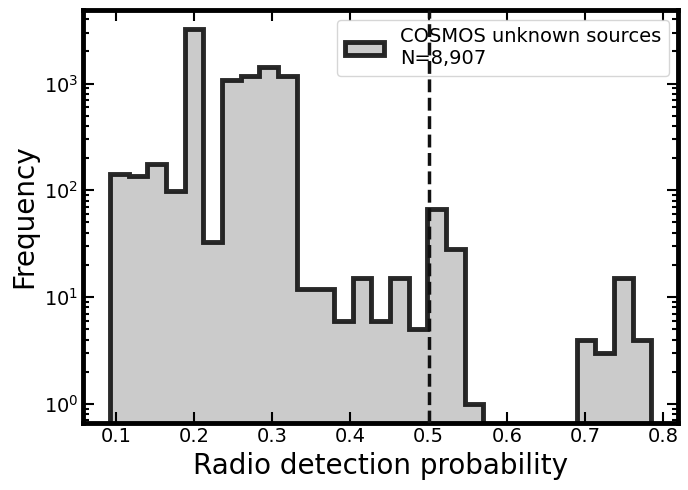

In [79]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_p, 'Prob_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_probs_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

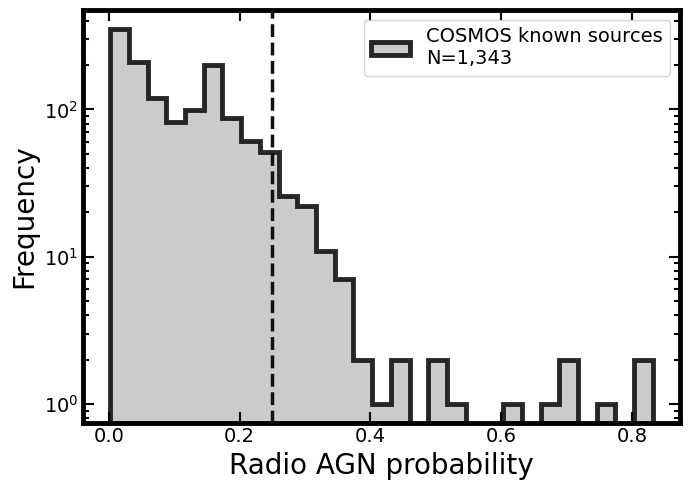

In [80]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
max_score       = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

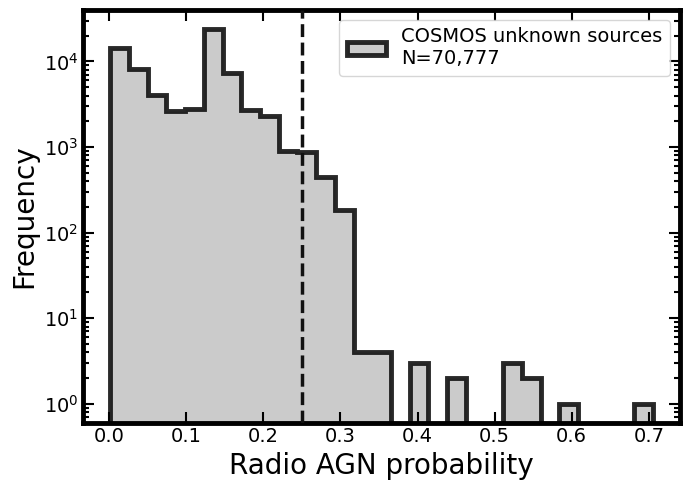

In [81]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_rAGN'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

Plot histograms for predicted and original redshifts.

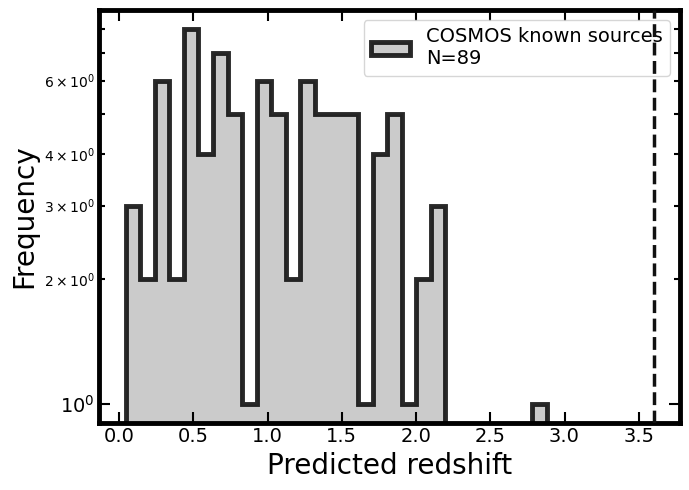

In [82]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_radio_AGN_p)

ax1.hist(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_redshift_rAGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

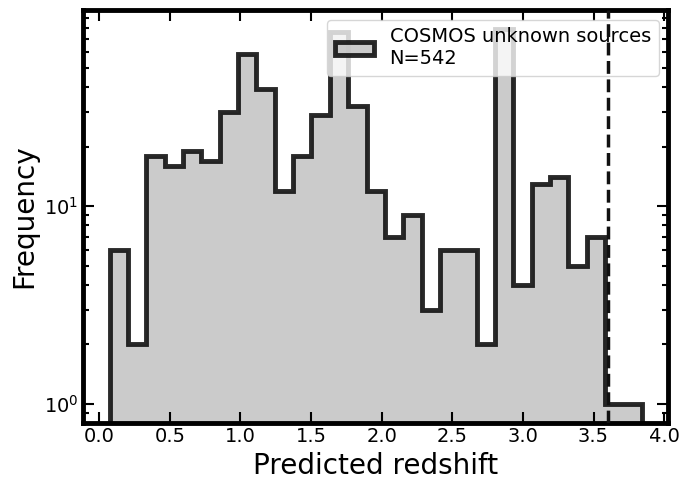

In [83]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_radio_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_redshift_rAGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

In [84]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
print('Predictions for known sources:')
display(full_catalog_df.loc[filter_radio_AGN_p, displayed_cols].describe())
print('\nPredictions for unknown sources:')
display(unknown_cat_df.loc[filter_radio_AGN_unk_p, displayed_cols].describe())

Predictions for known sources:


,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,89.0,89.0,89.000000,89.0,89.000000,89.000000
mean,1.0,1.0,0.842697,1.0,0.934157,1.075752
std,0.0,0.0,0.366149,0.0,0.635498,0.599073
min,1.0,1.0,0.000000,1.0,0.044000,0.046200
25%,1.0,1.0,1.000000,1.0,0.370000,0.599700
50%,1.0,1.0,1.000000,1.0,0.767000,1.028000
75%,1.0,1.0,1.000000,1.0,1.472000,1.502500
max,1.0,1.0,1.000000,1.0,2.536000,2.882000



Predictions for unknown sources:


,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,542.0,542.0,542.000000,542.0,5.000000,542.000000
mean,0.5,1.0,0.186347,1.0,0.480008,1.711253
std,0.0,0.0,0.389746,0.0,0.443836,0.863359
min,0.5,1.0,0.000000,1.0,0.000040,0.074300
25%,0.5,1.0,0.000000,1.0,0.300000,1.035325
50%,0.5,1.0,0.000000,1.0,0.400000,1.642250
75%,0.5,1.0,0.000000,1.0,0.500000,2.461825
max,0.5,1.0,1.000000,1.0,1.200000,3.841200


Add individual metrics for redshift

In [85]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [86]:
str_0_t     = f'Out of {total_size:,} initially known sources in {used_area},\n'
str_1_t     = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t     = f'{num_str_t:,} are listed as SDSS-DR16 stars and {num_AGN_t:,} are MQC AGN.\n'
str_3_t     = f'Also, {num_radio_AGN_t:,} AGN are detected in radio (i.e. Radio Galaxies).'

str_0_kno_p = f'Out of {len(full_catalog_df):,} initially known sources in {used_area},\n'
str_1_kno_p = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_kno_p = f'{num_str_p:,} are predicted as SDSS-DR16 stars and {num_AGN_p:,} are MQC AGN.\n'
str_3_kno_p = f'Also, {num_radio_AGN_p:,} AGN are predicted to bedetected in radio.'

str_0_unk_p = f'Out of {len(unknown_cat_df):,} initially unknown sources in {used_area},\n'
str_1_unk_p = f'{num_gal_unk_p:,} are predicted to be galaxies. On the other side,\n'
str_2_unk_p = f'{num_str_unk_p:,} are predicted as SDSS-DR16 stars and {num_AGN_unk_p:,} are MQC AGN.\n'
str_3_unk_p = f'Also, {num_radio_AGN_unk_p:,} AGN are predicted to be detected in radio.'

In [87]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)

print('-' * 60)
print(str_0_kno_p + str_1_kno_p + str_2_kno_p + str_3_kno_p)
print('-' * 60)

print('-' * 60)
print(str_0_unk_p + str_1_unk_p + str_2_unk_p + str_3_unk_p)
print('-' * 60)

------------------------------------------------------------
Out of 1,343 initially known sources in COSMOS,
331 are confirmed to be galaxies. On the other side,
0 are listed as SDSS-DR16 stars and 1,012 are MQC AGN.
Also, 514 AGN are detected in radio (i.e. Radio Galaxies).
------------------------------------------------------------
------------------------------------------------------------
Out of 1,343 initially known sources in COSMOS,
814 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 529 are MQC AGN.
Also, 89 AGN are predicted to bedetected in radio.
------------------------------------------------------------
------------------------------------------------------------
Out of 70,777 initially unknown sources in COSMOS,
61,870 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 8,907 are MQC AGN.
Also, 542 AGN are predicted to be detected in radio.
------------------------------------------------------

In [88]:
show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN',\
                'radio_detect', 'pred_radio', 'scaled_score_radio', 'scaled_score_rAGN', 'Z', 'pred_Z']

cols_4_table_pred_known   = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
                             'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'Z', 'pred_Z']
cols_4_table_pred_unknown = ['RA_ICRS', 'DE_ICRS', 'band_num', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
                             'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'pred_Z']

In [89]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = show_columns + cols_4_exp_all[used_area] + cols_photo

In [90]:
filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= gv.high_z_limit

Display properties of predicted Radio AGN in known sample.

In [91]:
display(full_catalog_df.loc[filter_radio_AGN_p, cols_4_table_pred_known].sort_values(by=['pred_Z'], ascending=False).head(20))

,RA_ICRS,DE_ICRS,band_num,class,Score_AGN,Prob_AGN,radio_detect,Score_radio,Prob_radio,Score_rAGN,Prob_rAGN,Z,pred_Z
46226,150.381638,2.505726,4,1.0,0.509398,0.474168,1,0.500055,0.315811,0.254727,0.149747,1.809,2.8820
3529,150.506271,2.058152,9,1.0,0.985437,0.957797,1,0.500015,0.333238,0.492733,0.319174,2.019,2.1894
5489,150.037201,2.244638,9,1.0,0.992972,0.352815,1,0.500053,0.719784,0.496538,0.253951,2.536,2.1802
62307,149.505600,2.724389,8,1.0,0.925153,0.849613,1,0.500058,0.251119,0.462630,0.213354,0.500,2.1749
37343,150.705566,2.629590,9,1.0,0.995125,0.687592,1,0.500009,0.252493,0.497571,0.173612,2.130,2.0506
55718,149.638611,2.288964,9,1.0,0.995056,0.930133,1,0.500007,0.207997,0.497535,0.193465,1.910,2.0372
57026,149.744598,2.027437,9,1.0,0.995467,0.907417,0,0.500012,0.216282,0.497746,0.196258,2.455,1.9672
8712,149.602066,2.392696,9,1.0,0.994028,0.666204,0,0.500013,0.275732,0.497026,0.183694,1.854,1.8933
49495,150.889862,2.758471,9,1.0,0.995289,0.900345,1,0.500016,0.362659,0.497661,0.326519,1.931,1.8645
69734,149.497910,2.076672,9,1.0,0.992949,0.614253,1,0.500015,0.348779,0.496489,0.214238,2.033,1.8518


Display properties predicted Radio AGN in unknown sample.

In [92]:
display(unknown_cat_df.loc[filter_radio_AGN_unk_p, cols_4_table_pred_unknown].sort_values(by=['pred_Z'], ascending=False).head(20))

,RA_ICRS,DE_ICRS,band_num,Score_AGN,Prob_AGN,radio_detect,Score_radio,Prob_radio,Score_rAGN,Prob_rAGN,pred_Z
70328,150.548523,2.381901,12,0.811469,0.059329,0,0.500008,0.101890,0.405741,0.006045,3.8412
17483,150.613617,1.750984,9,0.561278,0.064970,0,0.500009,0.265129,0.280644,0.017225,3.6652
44605,150.003799,1.685941,12,0.640319,0.030325,0,0.500008,0.102224,0.320165,0.003100,3.5527
66981,149.857895,2.279378,12,0.748026,0.055421,0,0.500005,0.101546,0.374017,0.005628,3.5437
13602,150.274017,2.472603,12,0.833203,0.044623,0,0.500009,0.335189,0.416609,0.014957,3.5287
39570,150.248657,2.297208,12,0.595457,0.030435,0,0.500008,0.104142,0.297733,0.003170,3.5208
65302,150.260818,2.285752,12,0.802320,0.041885,0,0.500008,0.125137,0.401167,0.005241,3.5099
68963,149.375443,1.532879,12,0.707276,0.030414,0,0.500007,0.106619,0.353643,0.003243,3.5077
48324,150.482605,2.458584,12,0.889489,0.051359,0,0.500009,0.144751,0.444753,0.007434,3.4967
60676,149.499298,2.479578,12,0.787499,0.072373,0,0.500009,0.164236,0.393757,0.011886,3.4337


Confusion matrix for AGN/galaxy prediction on all sources

In [93]:
MCC_AGN              = MCC_from_CM(cm_AGN)
ACC_AGN              = ACC_from_CM(cm_AGN)
F1_AGN               = F1_from_CM(cm_AGN)
Recall_AGN           = Recall_from_CM(cm_AGN)

MCC_AGN_prob         = MCC_from_CM(cm_AGN_prob)
ACC_AGN_prob         = ACC_from_CM(cm_AGN_prob)
F1_AGN_prob          = F1_from_CM(cm_AGN_prob)
Recall_AGN_prob      = Recall_from_CM(cm_AGN_prob)

Confusion matrix for radio detection prediction on all predicted AGN

In [94]:
MCC_radio            = MCC_from_CM(cm_radio)
ACC_radio            = ACC_from_CM(cm_radio)
F1_radio             = F1_from_CM(cm_radio)
Recall_radio         = Recall_from_CM(cm_radio)

MCC_radio_prob       = MCC_from_CM(cm_radio_prob)
ACC_radio_prob       = ACC_from_CM(cm_radio_prob)
F1_radio_prob        = F1_from_CM(cm_radio_prob)
Recall_radio_prob    = Recall_from_CM(cm_radio_prob)

Confusion matrix for radio AGN detection prediction.

In [95]:
MCC_radio_AGN         = MCC_from_CM(cm_rAGN)
ACC_radio_AGN         = ACC_from_CM(cm_rAGN)
F1_radio_AGN          = F1_from_CM(cm_rAGN)
Recall_radio_AGN      = Recall_from_CM(cm_rAGN)

MCC_radio_AGN_prob    = MCC_from_CM(cm_rAGN_prob)
ACC_radio_AGN_prob    = ACC_from_CM(cm_rAGN_prob)
F1_radio_AGN_prob     = F1_from_CM(cm_rAGN_prob)
Recall_radio_AGN_prob = Recall_from_CM(cm_rAGN_prob)

Join metrics for classification.

In [96]:
metrics_classif      = np.array([[np.sum(filter_known_spec), F1_AGN,       MCC_AGN,       Recall_AGN,       ACC_AGN],\
                                 [np.sum(filter_AGN_p),      F1_radio,     MCC_radio,     Recall_radio,     ACC_radio],\
                                 [np.sum(filter_known_spec), F1_radio_AGN, MCC_radio_AGN, Recall_radio_AGN, ACC_radio_AGN]])
metrics_classif_df   = pd.DataFrame(data=metrics_classif, columns=['Sample', 'F1', 'MCC', 'Recall', 'Accuracy'],\
                                    index=['AGN/Galaxy', 'Radio', 'Radio AGN'])

metrics_classif_prob      = np.array([[np.sum(filter_known_spec), F1_AGN_prob,       MCC_AGN_prob,       Recall_AGN_prob,       ACC_AGN_prob],\
                                 [np.sum(filter_AGN_prob_p),      F1_radio_prob,     MCC_radio_prob,     Recall_radio_prob,     ACC_radio_prob],\
                                 [np.sum(filter_known_spec), F1_radio_AGN_prob, MCC_radio_AGN_prob, Recall_radio_AGN_prob, ACC_radio_AGN_prob]])
metrics_classif_prob_df   = pd.DataFrame(data=metrics_classif_prob, columns=['Sample', 'F1', 'MCC', 'Recall', 'Accuracy'],\
                                    index=['AGN/Galaxy', 'Radio', 'Radio AGN'])

Confusion matrices for AGN criteria from literature

In [97]:
MCC_AGN_S12          = MCC_from_CM(cm_AGN_S12)
ACC_AGN_S12          = ACC_from_CM(cm_AGN_S12)
F1_AGN_S12           = F1_from_CM(cm_AGN_S12)
Recall_AGN_S12       = Recall_from_CM(cm_AGN_S12)

MCC_AGN_M12          = MCC_from_CM(cm_AGN_M12)
ACC_AGN_M12          = ACC_from_CM(cm_AGN_M12)
F1_AGN_M12           = F1_from_CM(cm_AGN_M12)
Recall_AGN_M12       = Recall_from_CM(cm_AGN_M12)

MCC_AGN_M16          = MCC_from_CM(cm_AGN_M16)
ACC_AGN_M16          = ACC_from_CM(cm_AGN_M16)
F1_AGN_M16           = F1_from_CM(cm_AGN_M16)
Recall_AGN_M16       = Recall_from_CM(cm_AGN_M16)

MCC_AGN_B18          = MCC_from_CM(cm_AGN_B18)
ACC_AGN_B18          = ACC_from_CM(cm_AGN_B18)
F1_AGN_B18           = F1_from_CM(cm_AGN_B18)
Recall_AGN_B18       = Recall_from_CM(cm_AGN_B18)

metrics_AGN_criteria    = np.array([[F1_AGN_S12,     F1_AGN_M12,     F1_AGN_M16,     F1_AGN_B18],\
                                    [MCC_AGN_S12,    MCC_AGN_M12,    MCC_AGN_M16,    MCC_AGN_B18],\
                                    [Recall_AGN_S12, Recall_AGN_M12, Recall_AGN_M16, Recall_AGN_B18],\
                                    [ACC_AGN_S12,    ACC_AGN_M12,    ACC_AGN_M16,    ACC_AGN_B18]]) 

metrics_AGN_criteria_df = pd.DataFrame(data=metrics_AGN_criteria.T, columns=['F1', 'MCC', 'Recall', 'Accuracy'],\
                                       index=['S12', 'M12', 'M16', 'B18'])

Join metrics for regression.

In [99]:
size_rAGN    = np.sum(filter_radio_AGN_p)
size_rAGN_hz = np.sum(filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z    = np.array([[size_rAGN, sigma_mad_early, sigma_nmad_early, sigma_z_early, sigma_z_norm_early, out_frac_early],\
                         [size_rAGN, sigma_mad_field, sigma_nmad_field, sigma_z_field, sigma_z_norm_field, out_frac_field],\
                         [size_rAGN_hz, sigma_mad_early_hiz, sigma_nmad_early_hiz, sigma_z_early_hiz, sigma_z_norm_early_hiz, out_frac_early_hiz],\
                         [size_rAGN_hz, sigma_mad_field_hiz, sigma_nmad_field_hiz, sigma_z_field_hiz, sigma_z_norm_field_hiz, out_frac_field_hiz]])
metrics_z_df = pd.DataFrame(data=metrics_z,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model high z', 'Second model high z'])

size_rAGN_prob    = np.sum(filter_radio_AGN_prob_p)
size_rAGN_prob_hz = np.sum(filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z_prob    = np.array([[size_rAGN_prob, sigma_mad_prob_early, sigma_nmad_prob_early, sigma_z_prob_early,\
                               sigma_z_norm_prob_early, out_frac_prob_early],\
                         [size_rAGN_prob, sigma_mad_prob_field, sigma_nmad_prob_field, sigma_z_prob_field,\
                          sigma_z_norm_prob_field, out_frac_prob_field],\
                         [size_rAGN_prob_hz, sigma_mad_prob_early_hiz, sigma_nmad_prob_early_hiz, sigma_z_prob_early_hiz,\
                          sigma_z_norm_prob_early_hiz, out_frac_prob_early_hiz],\
                         [size_rAGN_prob_hz, sigma_mad_prob_field_hiz, sigma_nmad_prob_field_hiz, sigma_z_prob_field_hiz,\
                          sigma_z_norm_prob_field_hiz, out_frac_prob_field_hiz]])
metrics_z_prob_df = pd.DataFrame(data=metrics_z_prob,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model high z', 'Second model high z'])

Print metrics

In [100]:
print('Metrics for classification steps along the pipeline using scores to obtain classes.')
metrics_classif_df.loc[:, 'Sample'] = metrics_classif_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_df)

Metrics for classification steps along the pipeline using scores to obtain classes.


,Sample,F1,MCC,Recall,Accuracy
AGN/Galaxy,1343,0.6840,0.4540,0.5208,0.6374
Radio,529,0.4274,0.3125,0.2863,0.6200
Radio AGN,1343,0.2488,0.2521,0.1459,0.6627


In [101]:
print('Metrics for classification steps along the pipeline using probabilities to obtain classes.')
metrics_classif_prob_df.loc[:, 'Sample'] = metrics_classif_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_prob_df)

Metrics for classification steps along the pipeline using probabilities to obtain classes.


,Sample,F1,MCC,Recall,Accuracy
AGN/Galaxy,1343,0.6693,0.4220,0.5079,0.6217
Radio,524,0.0880,0.1262,0.0464,0.5649
Radio AGN,1343,0.0342,0.0630,0.0175,0.6210


In [102]:
print('Metrics for AGN detection criteria (from literature).')
print(f'Sample size, N = {np.sum(filter_known_spec):,}')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_AGN_criteria_df)

Metrics for AGN detection criteria (from literature).
Sample size, N = 1,343


,F1,MCC,Recall,Accuracy
S12,0.7203,0.4769,0.5662,0.6687
M12,0.2609,0.1996,0.1502,0.3589
M16,0.4306,0.2750,0.2757,0.4505
B18,0.5788,0.3611,0.4101,0.5503


In [103]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by scores')
metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by scores


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,89,0.1934,0.0938,0.3777,0.2408,0.2472
Two models,89,0.1934,0.0938,0.3777,0.2408,0.2472
First model high z,0,NaN,NaN,NaN,NaN,NaN
Second model high z,0,NaN,NaN,NaN,NaN,NaN


In [104]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities')
metrics_z_prob_df.loc[:, 'Sample'] = metrics_z_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_prob_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,13,0.8002,0.5695,0.9561,0.6667,0.6154
Two models,13,0.8002,0.5695,0.9561,0.6667,0.6154
First model high z,0,NaN,NaN,NaN,NaN,NaN
Second model high z,0,NaN,NaN,NaN,NaN,NaN


## Plot predictions

### Classifications based on scores

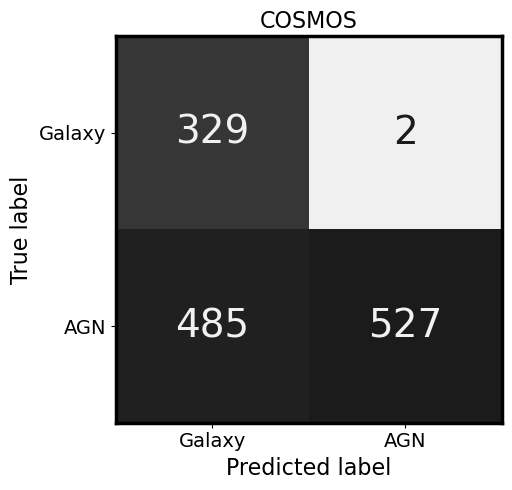

In [105]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

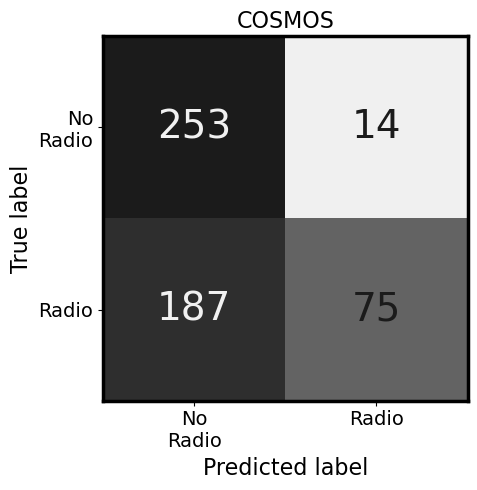

In [106]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

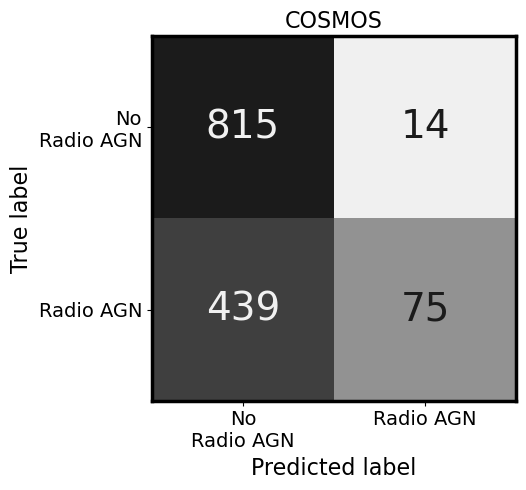

In [107]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_rAGN, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Classifications based on probabilities

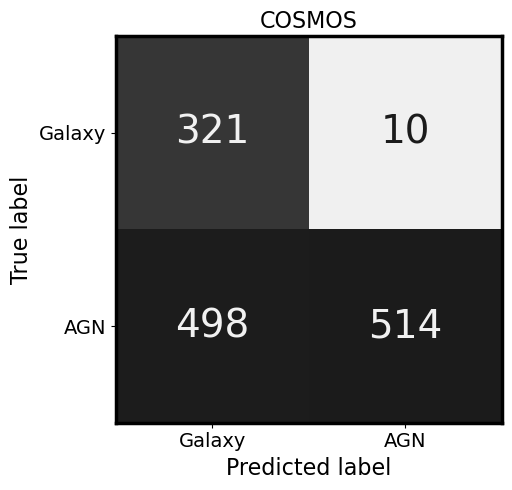

In [108]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN_prob, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

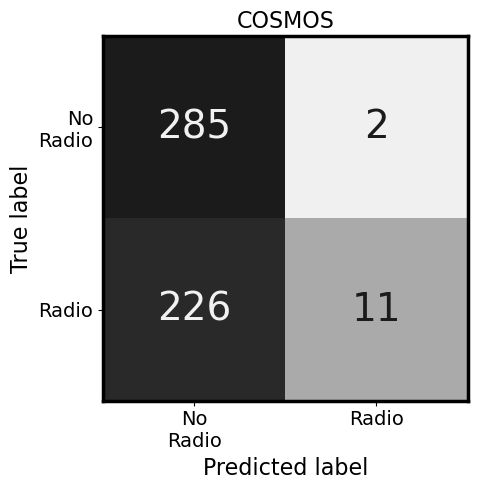

In [109]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_prob, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

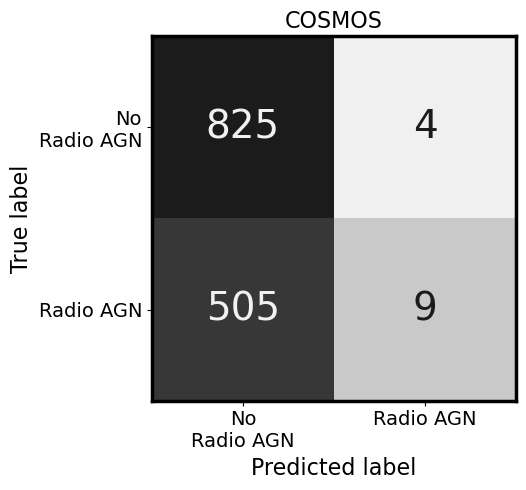

In [110]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_rAGN_prob, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Regression from sources by scores

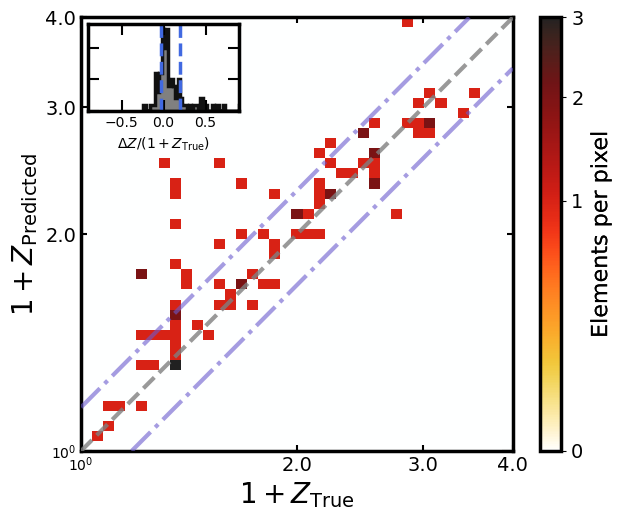

In [111]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)

if save_plot_flag:
    plt.savefig(gv.plots_path + f'compare_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Regression from sources by probabilities

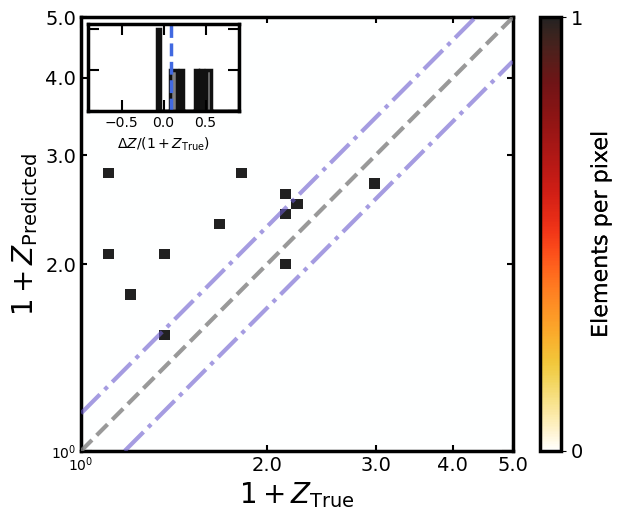

In [112]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)

if save_plot_flag:
    plt.savefig(gv.plots_path + f'compare_redshift_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

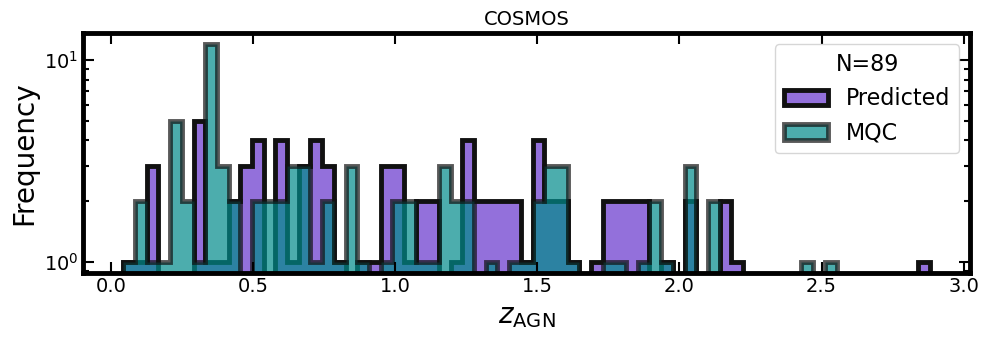

In [113]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(full_catalog_df.loc[filter_radio_AGN_p, 'Z']),\
                           np.nanmin(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])])
max_for_range = np.nanmax([np.nanmax(full_catalog_df.loc[filter_radio_AGN_p, 'Z']),\
                           np.nanmax(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])])
bins_z        = np.linspace(min_for_range, max_for_range, 70)



_, bins, _ = ax1.hist(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')
ax1.hist(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], bins=bins_z, histtype='stepfilled', ec='k',\
         fc='darkcyan', lw=3.5, label=f'MQC', alpha=0.7)

# ax1.axvline(x=3.6, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=3.7, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=3.8, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=3.9, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=4.0, ls='--', c='k', lw=2.5, zorder=10)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_true_predicted_z_{used_area}.pdf')
plt.show()

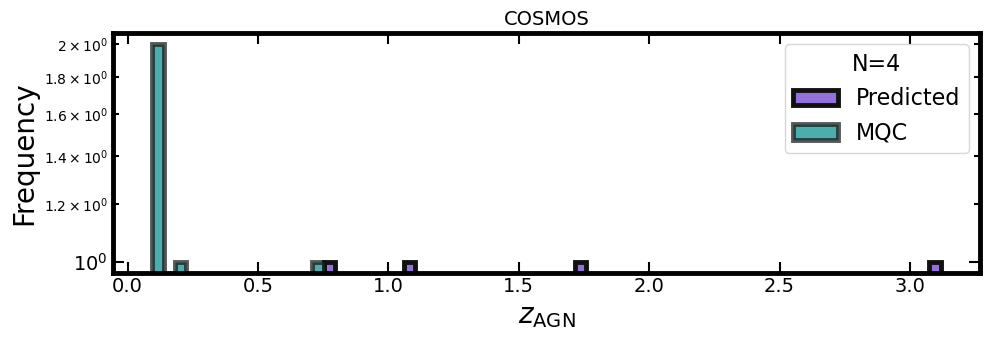

In [114]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(full_catalog_df.loc[filt_new_rAGN_prob_p, 'Z']),\
                           np.nanmin(full_catalog_df.loc[filt_new_rAGN_prob_p, 'pred_Z'])])
max_for_range = np.nanmax([np.nanmax(full_catalog_df.loc[filt_new_rAGN_prob_p, 'Z']),\
                           np.nanmax(full_catalog_df.loc[filt_new_rAGN_prob_p, 'pred_Z'])])
bins_z        = np.linspace(min_for_range, max_for_range, 70)



_, bins, _ = ax1.hist(full_catalog_df.loc[filt_new_rAGN_prob_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')
ax1.hist(full_catalog_df.loc[filt_new_rAGN_prob_p, 'Z'], bins=bins_z, histtype='stepfilled', ec='k',\
         fc='darkcyan', lw=3.5, label=f'MQC', alpha=0.7)

# ax1.axvline(x=3.6, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=3.7, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=3.8, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=3.9, ls='--', c='k', lw=2.5, zorder=10)
# ax1.axvline(x=4.0, ls='--', c='k', lw=2.5, zorder=10)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filt_new_rAGN_prob_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_true_predicted_z_prob_{used_area}.pdf')
plt.show()

### Results from unknown sources

In [115]:
unk_summary_AGN_gal                   = unknown_cat_df.loc[:, 'Score_AGN'].groupby(unknown_cat_df.loc[:, 'pred_class']).describe()
unk_summary_AGN_gal_probs             = unknown_cat_df.loc[:, 'Prob_AGN'].groupby(unknown_cat_df.loc[:, 'pred_class']).describe()
unk_summary_radio                     = unknown_cat_df.loc[filter_AGN_unk_p,
                                                         'Score_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_p,
                                                                                                   'pred_radio']).describe()
unk_summary_radio_probs               = unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                         'Prob_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                                                                   'pred_radio']).describe()
unk_summary_z                         = unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'].describe()
unk_summary_z_probs                   = unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'].describe()
unk_summary_AGN_radio                 = pd.concat([unk_summary_AGN_gal, unk_summary_AGN_gal_probs, unk_summary_radio, unk_summary_radio_probs])
unk_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
unk_summary_AGN_radio                 = unk_summary_AGN_radio.set_index('Prediction', drop=True)
unk_summary_AGN_radio.loc['Z']        = unk_summary_z
unk_summary_AGN_radio.loc['Z (prob)'] = unk_summary_z_probs

In [116]:
unk_summary_AGN_radio.loc[:, 'count'] = unk_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(unk_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,61870,0.22043,0.14780,0.00276,0.06160,0.28733,0.34319,0.49995
AGN,8907,0.68698,0.12930,0.50002,0.57293,0.67166,0.77445,0.99571
Galaxy (prob),61870,0.38354,0.23148,0.02905,0.12867,0.50753,0.55342,1.00000
AGN (prob),8907,0.58166,0.30610,0.03017,0.35847,0.62346,0.84275,1.00000
No radio,8365,0.49988,0.00003,0.49986,0.49986,0.49986,0.49987,0.50000
Radio,542,0.50002,0.00003,0.50000,0.50001,0.50001,0.50004,0.50013
No radio (prob),36721,0.26505,0.02791,0.11168,0.26513,0.26513,0.26513,0.72075
Radio (prob),87,0.29639,0.13504,0.16895,0.21049,0.26248,0.30462,0.78486
Z,542,1.71125,0.86336,0.07430,1.03533,1.64225,2.46182,3.84120


#### Same idea for known sample.

In [117]:
kno_summary_AGN_gal                   = full_catalog_df.loc[:, 'Score_AGN'].groupby(full_catalog_df.loc[:, 'pred_class']).describe()
kno_summary_AGN_gal_probs             = full_catalog_df.loc[:, 'Prob_AGN'].groupby(full_catalog_df.loc[:, 'pred_class']).describe()
kno_summary_radio                     = full_catalog_df.loc[filter_AGN_p,
                                                         'Score_radio'].groupby(full_catalog_df.loc[filter_AGN_p,
                                                                                                   'pred_radio']).describe()
kno_summary_radio_probs               = full_catalog_df.loc[filter_AGN_prob_p,
                                                         'Prob_radio'].groupby(full_catalog_df.loc[filter_AGN_prob_p,
                                                                                                   'pred_radio']).describe()
kno_summary_z                         = full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'].describe()
kno_summary_z_probs                   = full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'].describe()
kno_summary_AGN_radio                 = pd.concat([kno_summary_AGN_gal, kno_summary_AGN_gal_probs, kno_summary_radio, kno_summary_radio_probs])
kno_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
kno_summary_AGN_radio                 = kno_summary_AGN_radio.set_index('Prediction', drop=True)
kno_summary_AGN_radio.loc['Z']        = kno_summary_z
kno_summary_AGN_radio.loc['Z (prob)'] = kno_summary_z_probs

In [118]:
kno_summary_AGN_radio.loc[:, 'count'] = kno_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(kno_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,814,0.14216,0.14978,0.00309,0.01087,0.07048,0.28327,0.49835
AGN,529,0.88179,0.13890,0.50381,0.80628,0.94527,0.99304,0.99712
Galaxy (prob),814,0.25423,0.21593,0.03094,0.07623,0.14977,0.45883,0.99295
AGN (prob),529,0.62965,0.31481,0.03010,0.35438,0.68940,0.94332,1.00000
No radio,440,0.49990,0.00004,0.49986,0.49987,0.49988,0.49994,0.50000
Radio,89,0.50004,0.00004,0.50000,0.50001,0.50002,0.50006,0.50012
No radio (prob),470,0.25275,0.04514,0.14065,0.20962,0.26513,0.27888,0.72075
Radio (prob),54,0.38578,0.20210,0.15729,0.25146,0.34178,0.37165,0.83229
Z,89,1.07575,0.59907,0.04620,0.59970,1.02800,1.50250,2.88200


---

## Additional test with data from Ananna et al., 2017

In [119]:
if compare_A17_flag:
    full_catalog_A17_df = pd.read_hdf(gv.cat_path + gv.file_S82_Ananna_17, key='df').drop(columns=features_2_discard)

In [120]:
if compare_A17_flag:
    full_catalog_A17_df = pyr.predict_model(redshift_reg, data=full_catalog_A17_df, round=8)
    full_catalog_A17_df = full_catalog_A17_df.rename(columns={'Label': 'pred_Z', 'is_AGN': 'class'})
    full_catalog_A17_df['pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    redshift_tol   = 0.0
    if use_second_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_2, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)

In [121]:
if compare_A17_flag:
    sigma_mad_AGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_AGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_AGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_AGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_AGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [122]:
if compare_A17_flag:
    size_AGN_A17         = np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"]))
    metrics_z_AGN_A17    = np.array([size_AGN_A17, sigma_mad_AGN_A17, sigma_nmad_AGN_A17, sigma_z_AGN_A17,
                                     sigma_z_norm_AGN_A17, out_frac_AGN_A17])
    metrics_z_A17_df = pd.DataFrame(columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])
    metrics_z_A17_df.loc['AGN'] = metrics_z_AGN_A17

In [123]:
if compare_A17_flag:
    fig              = plt.figure(figsize=(7.5,4.3))
    ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
    
    min_score        = np.nanmin([np.nanmin(full_catalog_A17_df.loc[:, 'zsp']), np.nanmin(full_catalog_A17_df.loc[:, 'pred_Z'])])
    max_score        = np.nanmax([np.nanmax(full_catalog_A17_df.loc[:, 'zsp']), np.nanmax(full_catalog_A17_df.loc[:, 'pred_Z'])])
    score_bins       = np.linspace(min_score, max_score, 30)
    
    sample_size_orig = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']))
    sample_size_pred = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    
    ax1.hist(full_catalog_A17_df.loc[:, 'zsp'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.8,\
             label=f'Original\nN={sample_size_orig:,}', zorder=2)
    ax1.hist(full_catalog_A17_df.loc[:, 'pred_Z'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
             label=f'Predicted\nN={sample_size_pred:,}', zorder=1)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    ax1.set_title('S82: Ananna+17')
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'hist_redshift_AGN_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()

In [124]:
if compare_A17_flag:
    full_catalog_A17_df = full_catalog_A17_df.loc[np.array(full_catalog_A17_df.loc[:, 'class'] == 1) &\
                                                  np.array(full_catalog_A17_df.loc[:, 'radio_detect'] == 1)]

In [125]:
if compare_A17_flag:
    used_z_col = 'zsp'
    full_catalog_A17_df['Delta_z_N'] = np.around((full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                 (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)
    full_catalog_A17_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                  (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)

In [126]:
if compare_A17_flag:
    show_columns_A17 = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'Z', 'zsp', 'pred_Z', 'Delta_z_N']
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by='pred_Z', ascending=False).head(10))
        display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by=used_z_col, ascending=False).head(10))

In [127]:
if compare_A17_flag:
    sigma_mad_rAGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_rAGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_rAGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_rAGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_rAGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [128]:
if compare_A17_flag:
    size_rAGN_A17     = np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"]))
    metrics_z_rAGN_A17    = np.array([size_rAGN_A17, sigma_mad_rAGN_A17, sigma_nmad_rAGN_A17, sigma_z_rAGN_A17,
                                 sigma_z_norm_rAGN_A17, out_frac_rAGN_A17])
    metrics_z_A17_df.loc['Radio AGN'] = metrics_z_rAGN_A17

In [129]:
if compare_A17_flag:
    print('Metrics for redshift predictions in all AGN and Radio AGN from Ananna et al., 2017 with counterparts in our sample')
    metrics_z_A17_df.loc[:, 'Sample'] = metrics_z_A17_df.loc[:, 'Sample'].astype(int)
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(metrics_z_A17_df)

In [130]:
if compare_A17_flag:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    plot_redshift_compare(full_catalog_A17_df.loc[:, used_z_col], full_catalog_A17_df.loc[:, 'pred_Z'],\
                          ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'compare_redshift_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()